In [1]:
#Run a function file that has functions for importing sql data, simple filters, and visual dots
%run PVModel_Functions.py

In [8]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import datatools
import datetime
import pvlib
import math
import statistics

from sklearn.metrics import mean_squared_error
from math import sqrt

from pvpltools import iec61853
from pvpltools.module_efficiency import adr,heydenreich,motherpv,pvgis,mpm5,mpm6,bilinear,fit_efficiency_model,fit_bilinear 

#Set plotting format
%matplotlib inline 
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1)
q = 1.60218e-19  # Elementary charge in units of coulombs
kb = 1.38066e-23
t = 298.15

In [3]:
mod_names = ['Panasonic','Can275']

In [62]:
results = []

In [63]:
for mod_name in mod_names:
        
    #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients_bhk.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]

    if mod_name == 'Panasonic':
        inputs = pd.read_excel('Blind_Comp.xlsx')
        daterng_all = pd.date_range(start='01/01/2020', end='01/01/2021', freq='H')
        daterng_all = daterng_all[~((daterng_all.month == 2) & (daterng_all.day == 29))]
        daterng_all = daterng_all.drop(daterng_all[0])
        inputs.index = daterng_all
        inputs.index = inputs.index.tz_localize('MST')
        
        filters = pd.read_csv('filters_8760.csv', index_col=0)
        inputs = inputs.merge(filters, on=filters.index)
        inputs.index = daterng_all.tz_localize('MST')

        inputs = inputs.loc[(inputs['DTU Filter 2'] ==1) & (inputs['DTU Filter 3'] ==1) & (inputs['DTU Filter 4'] ==1) & (inputs['solarGIS_bsrn_pass'] ==1) & (inputs['SNL No Snow'] ==1)]
        inputs.drop(['DTU Filter 2', 'DTU Filter 3', 'DTU Filter 4','solarGIS_bsrn_pass', 'SNL No Snow'], axis=1, inplace=True)
        
        
    else:
        inputs = pd.read_excel('Blind_Comp_Can275.xlsx')
        daterng_all = pd.date_range(start='01/01/2020', end='01/01/2021', freq='H')
        daterng_all = daterng_all[~((daterng_all.month == 2) & (daterng_all.day == 29))]
        daterng_all = daterng_all.drop(daterng_all[0])
        inputs.index = daterng_all
        inputs.index = inputs.index.tz_localize('MST')

        
        # calculate solarposition info (azimuth, zenith, etc)
    inputs = inputs.loc[inputs['Measured POA irradiance'] > 100]
    inputs = inputs.loc[inputs['Measured DC power'] > 50]
    inputs.replace(0, np.nan, inplace=True)
    
    #Calculate Solar Positions & Extraterrestrial DNI
    pres = pvlib.atmosphere.alt2pres(module['altitude'])
    sdf = pvlib.solarposition.get_solarposition(time=inputs.index, latitude=module['latitude'], 
            longitude=module['longitude'],temperature=inputs['Ambient Temp'], altitude=module['altitude'])
    inputs['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=inputs.index)
    
    aoi = pvlib.irradiance.aoi(surface_tilt=module['tilt'], surface_azimuth=module['surface_azimuth'], 
            solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
    inputs['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])
    inputs['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=inputs['airmass'], pressure=pres)
    
    poa_direct = (inputs['DNI'] * np.cos(np.radians(aoi)))
    poa_direct[poa_direct < 0] = 0
    poa_diffuse = pvlib.irradiance.perez(surface_tilt = module['tilt'], surface_azimuth=module['surface_azimuth'],
    dhi=inputs['DHI'],dni=inputs['DNI'], dni_extra=inputs['dni_extra'], solar_zenith=sdf['apparent_zenith'], 
    solar_azimuth=sdf['azimuth'], airmass=inputs['airmass'], model = 'allsitescomposite1988')
    poa_global = (poa_diffuse + poa_direct)
    
    #Calculate Effective Irradiance
    ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
    ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
                module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
    F2 = pvlib.iam.interp(aoi=aoi,theta_ref=ref_thetas,iam_ref=ref_iams )
    eff_irr = (poa_direct * F2 + module['FD'] * poa_diffuse)
    
    
    #second if statement here for mod temperature model
    mod_temp = pvlib.temperature.faiman(poa_global=poa_global, temp_air=inputs['Ambient Temp'], 
                wind_speed=inputs['Wind Speed'], u0=module['U0'], u1=module['U1'])
    #cell_temp = mod_temp
    cell_temp = pvlib.temperature.sapm_cell_from_module(module_temperature=mod_temp, poa_global=poa_global, deltaT=3)
    #mod_temp = cell_temp
    
    #assuming 2% losses
    
    #Run SAPM and calculate string power
    dc = pvlib.pvsystem.sapm(effective_irradiance=eff_irr, temp_cell=cell_temp, module=module)
    sapm_results = (dc['v_mp']*dc['i_mp']*module['str_len']*0.98).to_frame()
    
    #Organize model results and other metrics that can be used for comparison
    sapm_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    sapm_results['DC Power'] = inputs['Measured DC power']
    sapm_results['Min DC Power'] = inputs['Measured min DC power']
    sapm_results['Max DC Power'] = inputs['Measured max DC power']
    sapm_results['DGpower_%'] = 100*((sapm_results['Modeled Power']-sapm_results['DC Power'])/sapm_results['DC Power'])
    sapm_results['DGpower_W'] = (sapm_results['Modeled Power']-sapm_results['DC Power'])
    sapm_results['Irradiance'] = eff_irr
    sapm_results['Cell/Mod Temperature'] = cell_temp
#     sapm_results['Sol Elev'] = df['apparent_elevation']
#     sapm_results['Sol Azim'] = df['azimuth']
    sapm_results['Time'] = sapm_results.index
    sapm_results['Model Name'] = 'SAPM'
    sapm_results['System'] = mod_name
    results.append(sapm_results)
    
    
    #Run PVW and calculate string power
    pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = eff_irr, temp_cell = cell_temp, 
                pdc0 = (module['p_mp']/module['gain_pmp']),gamma_pdc = (module['gamma_pmp']/100))
    pvw_results = (pvw_pdc*module['str_len']*0.98).to_frame()

        #Organize model results and other metrics that can be used for comparison
    pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    pvw_results['DC Power'] = inputs['Measured DC power']
    pvw_results['Min DC Power'] = inputs['Measured min DC power']
    pvw_results['Max DC Power'] = inputs['Measured max DC power']
    pvw_results['DGpower_%'] = 100*((pvw_results['Modeled Power']-pvw_results['DC Power'])/pvw_results['DC Power'])
    pvw_results['DGpower_W'] = (pvw_results['Modeled Power']-pvw_results['DC Power'])
    pvw_results['Irradiance'] = eff_irr
    pvw_results['Cell/Mod Temperature'] = cell_temp
#     pvw_results['Sol Elev'] = df['apparent_elevation']
#     pvw_results['Sol Azim'] = df['azimuth']
    pvw_results['Time'] = pvw_results.index
    pvw_results['Model Name'] = 'PVW'
    pvw_results['System'] = mod_name
    results.append(pvw_results)
    
    cec_ivt = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['cell_type'], v_mp=(module['v_mp']/module['gain_vmp']), 
                    i_mp=(module['i_mp']/module['gain_imp']),v_oc=(module['v_oc']/module['gain_voc']),
                    i_sc=(module['i_sc']/module['gain_isc']), alpha_sc=module['alpha_sc'], beta_voc=module['beta_voc'],
                    gamma_pmp=module['gamma_pmp'], cells_in_series=module['Cells_in_Series'])
    I_L_ref = cec_ivt[0]
    I_o_ref = cec_ivt[1]
    R_s = cec_ivt[2]
    R_sh_ref = cec_ivt[3]
    a_ref = cec_ivt[4]
    Adjust = cec_ivt[5]
    gamma_ref=(a_ref/module['Cells_in_Series'])*(q/(kb*t))
    
    
    #Calculate parameters necessary to input into single diode model
    cec_param = pvlib.pvsystem.calcparams_cec(effective_irradiance=eff_irr, temp_cell=cell_temp, 
                            alpha_sc=module['alpha_sc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, 
                            R_sh_ref=R_sh_ref, R_s=R_s,Adjust=Adjust,EgRef=1.121)
    #Calculate power using single diode model
    cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], 
                resistance_series =cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
    #Calculate string power
    cec_results = (cec_p['p_mp']*module['str_len']*0.98).to_frame()

    #Organize model results and other metrics that can be used for comparison
    cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    cec_results['DC Power'] = inputs['Measured DC power']
    cec_results['Min DC Power'] = inputs['Measured min DC power']
    cec_results['Max DC Power'] = inputs['Measured max DC power']
    cec_results['DGpower_%'] = 100*((cec_results['Modeled Power']-cec_results['DC Power'])/cec_results['DC Power'])
    cec_results['DGpower_W'] = (cec_results['Modeled Power']-cec_results['DC Power'])
    cec_results['Irradiance'] = eff_irr
    cec_results['Cell/Mod Temperature'] = cell_temp
#     cec_results['Sol Elev'] = df['apparent_elevation']
#     cec_results['Sol Azim'] = df['azimuth']
    cec_results['Time'] = cec_results.index
    cec_results['Model Name'] = 'CEC'
    cec_results['System'] = mod_name
    results.append(cec_results)
    

    #Calculate parameters necessary to input into single diode model
    ds_param = pvlib.pvsystem.calcparams_desoto(effective_irradiance=eff_irr,temp_cell=cell_temp, 
            alpha_sc=module['alpha_sc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, R_sh_ref=R_sh_ref,R_s=R_s, EgRef=1.121)
    #Calculate power using single diode model
    ds_p = pvlib.pvsystem.singlediode(photocurrent=ds_param[0],saturation_current = ds_param[1],resistance_series=ds_param[2], 
                            resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
    #Calculate string power
    des_results = (ds_p['p_mp']*module['str_len']*0.98).to_frame()
    
    #Organize model results and other metrics that can be used for comparison
    des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    des_results['DC Power'] = inputs['Measured DC power']
    des_results['Min DC Power'] = inputs['Measured min DC power']
    des_results['Max DC Power'] = inputs['Measured max DC power']
    des_results['DGpower_%'] = 100*((des_results['Modeled Power']-des_results['DC Power'])/des_results['DC Power'])
    des_results['DGpower_W'] = (des_results['Modeled Power']-des_results['DC Power'])
    des_results['Irradiance'] = eff_irr
    des_results['Cell/Mod Temperature'] = cell_temp
#     des_results['Sol Elev'] = df['apparent_elevation']
#     des_results['Sol Azim'] = df['azimuth']
    des_results['Time'] = des_results.index
    des_results['Model Name'] = 'DES'
    des_results['System'] = mod_name
    results.append(des_results)
    
    
    
    #Calculate parameters necessary to input into single diode model
    pvs_param = pvlib.pvsystem.calcparams_pvsyst(effective_irradiance=eff_irr,temp_cell=cell_temp, 
                alpha_sc=module['alpha_sc'],gamma_ref=gamma_ref,mu_gamma=module['mu_gamma'], I_L_ref=I_L_ref,I_o_ref=I_o_ref,
                R_sh_ref=R_sh_ref, R_sh_0=module['R_sh_0'],R_s=R_s,cells_in_series=module['Cells_in_Series'], EgRef=1.121)
    #Calculate power using single diode model
    pvs_p = pvlib.pvsystem.singlediode(photocurrent=pvs_param[0],saturation_current =pvs_param[1],resistance_series=pvs_param[2],
            resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
    #Calculate string power
    pvs_results = (pvs_p['p_mp']*module['str_len']*0.98).to_frame()
    
    #Organize model results and other metrics that can be used for comparison
    pvs_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    pvs_results['DC Power'] = inputs['Measured DC power']
    pvs_results['Min DC Power'] = inputs['Measured min DC power']
    pvs_results['Max DC Power'] = inputs['Measured max DC power']
    pvs_results['DGpower_%'] = 100*((pvs_results['Modeled Power']-pvs_results['DC Power'])/pvs_results['DC Power'])
    pvs_results['DGpower_W'] = (pvs_results['Modeled Power']-pvs_results['DC Power'])
    pvs_results['Irradiance'] = eff_irr
    pvs_results['Cell/Mod Temperature'] = cell_temp
#     pvs_results['Sol Elev'] = df['apparent_elevation']
#     pvs_results['Sol Azim'] = df['azimuth']
    pvs_results['Time'] = pvs_results.index
    pvs_results['Model Name'] = 'PVS'
    pvs_results['System'] = mod_name
    results.append(pvs_results)
    
    #Import matrix of measurement data
    measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
    matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
    matrix.columns = ['temperature', 'irradiance', 'p_mp']
    # calculate efficiency from power
    matrix = matrix.eval('eta = p_mp / irradiance')
    eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
    matrix.eta /= eta_stc.values
    # just keep the columns that are needed
    matrix = matrix[['irradiance', 'temperature', 'eta']]
    
    #Calculate ADR results and add to df
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=adr)
    #Calculate eff. using adr model
    adr_eff = adr(eff_irr,mod_temp,*popt)
    #Calculate power given the above adr eff. 
    adr_results = (((eff_irr/1000) * (adr_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']*0.98).to_frame()

    #Organize model results and other metrics that can be used for comparison
    adr_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    adr_results['DC Power'] = inputs['Measured DC power']
    adr_results['Min DC Power'] = inputs['Measured min DC power']
    adr_results['Max DC Power'] = inputs['Measured max DC power']
    adr_results['DGpower_%'] = 100*((adr_results['Modeled Power']-adr_results['DC Power'])/adr_results['DC Power'])
    adr_results['DGpower_W'] = (adr_results['Modeled Power']-adr_results['DC Power'])
    adr_results['Irradiance'] = eff_irr
    adr_results['Cell/Mod Temperature'] = mod_temp
#     adr_results['Sol Elev'] = df['apparent_elevation']
#     adr_results['Sol Azim'] = df['azimuth']
    adr_results['Time'] = adr_results.index
    adr_results['Model Name'] = 'ADR'
    adr_results['System'] = mod_name
    results.append(adr_results)
    
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance, temperature=matrix.temperature,
                                    eta=matrix.eta, model=heydenreich)
    hey_eff = heydenreich(eff_irr, mod_temp, *popt)
    hey_results = (((eff_irr/1000) * (hey_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']*0.98).to_frame()
    
    hey_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    hey_results['DC Power'] = inputs['Measured DC power']
    hey_results['Min DC Power'] = inputs['Measured min DC power']
    hey_results['Max DC Power'] = inputs['Measured max DC power']
    hey_results['DGpower_%'] = 100*((hey_results['Modeled Power']-hey_results['DC Power'])/hey_results['DC Power'])
    hey_results['DGpower_W'] = (hey_results['Modeled Power']-hey_results['DC Power'])
    hey_results['Irradiance'] = eff_irr
    hey_results['Cell/Mod Temperature'] = mod_temp
#     hey_results['Sol Elev'] = df['apparent_elevation']
#     hey_results['Sol Azim'] = df['azimuth']
    hey_results['Time'] = hey_results.index
    hey_results['Model Name'] = 'HEY'
    hey_results['System'] = mod_name
    results.append(hey_results)
    
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=motherpv)
    mother_eff = motherpv(eff_irr, mod_temp, *popt)
    mot_results = (((eff_irr/1000) * (mother_eff) * (module['p_mp']/module['gain_pmp'])) * module['str_len']*0.98).to_frame()
    
    mot_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    mot_results['DC Power'] = inputs['Measured DC power']
    mot_results['Min DC Power'] = inputs['Measured min DC power']
    mot_results['Max DC Power'] = inputs['Measured max DC power']
    mot_results['DGpower_%'] = 100*((mot_results['Modeled Power']-mot_results['DC Power'])/mot_results['DC Power'])
    mot_results['DGpower_W'] = (mot_results['Modeled Power']-mot_results['DC Power'])
    mot_results['Irradiance'] = eff_irr
    mot_results['Cell/Mod Temperature'] = mod_temp
#     mot_results['Sol Elev'] = df['apparent_elevation']
#     mot_results['Sol Azim'] = df['azimuth']
    mot_results['Time'] = mot_results.index
    mot_results['Model Name'] = 'MOT'
    mot_results['System'] = mod_name
    results.append(mot_results)
    
    
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=pvgis)
    pvgis_eff = pvgis(eff_irr, mod_temp, *popt)
    pvg_results = (((eff_irr/1000) * (pvgis_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']*0.98).to_frame()
    
    pvg_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    pvg_results['DC Power'] = inputs['Measured DC power']
    pvg_results['Min DC Power'] = inputs['Measured min DC power']
    pvg_results['Max DC Power'] = inputs['Measured max DC power']
    pvg_results['DGpower_%'] = 100*((pvg_results['Modeled Power']-pvg_results['DC Power'])/pvg_results['DC Power'])
    pvg_results['DGpower_W'] = (pvg_results['Modeled Power']-pvg_results['DC Power'])
    pvg_results['Irradiance'] = eff_irr
    pvg_results['Cell/Mod Temperature'] = mod_temp
#     pvg_results['Sol Elev'] = df['apparent_elevation']
#     pvg_results['Sol Azim'] = df['azimuth']
    pvg_results['Time'] = pvg_results.index
    pvg_results['Model Name'] = 'PVG'
    pvg_results['System'] = mod_name
    results.append(pvg_results)
    
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm5)
    mpm5_eff = mpm5(eff_irr, mod_temp, *popt)
    mpm5_results = (((eff_irr/1000) * (mpm5_eff) * (module['p_mp']/module['gain_pmp'])) *module['str_len']*0.98).to_frame()
    
    mpm5_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    mpm5_results['DC Power'] = inputs['Measured DC power']
    mpm5_results['Min DC Power'] = inputs['Measured min DC power']
    mpm5_results['Max DC Power'] = inputs['Measured max DC power']
    mpm5_results['DGpower_%'] = 100*((mpm5_results['Modeled Power']-mpm5_results['DC Power'])/mpm5_results['DC Power'])
    mpm5_results['DGpower_W'] = (mpm5_results['Modeled Power']-mpm5_results['DC Power'])
    mpm5_results['Irradiance'] = eff_irr
    mpm5_results['Cell/Mod Temperature'] = mod_temp
#     mpm5_results['Sol Elev'] = df['apparent_elevation']
#     mpm5_results['Sol Azim'] = df['azimuth']
    mpm5_results['Time'] = mpm5_results.index
    mpm5_results['Model Name'] = 'MPM5'
    mpm5_results['System'] = mod_name
    results.append(mpm5_results)
    
    #Determine the parameters for the eff. model using non-linear least squares fit
    popt, pcov = fit_efficiency_model(irradiance=matrix.irradiance,temperature=matrix.temperature,eta=matrix.eta,model=mpm6)
    mpm6_eff = mpm6(eff_irr, mod_temp, *popt)
    mpm6_results = (((eff_irr/1000) * (mpm6_eff) * (module['p_mp']/module['gain_pmp']) )*module['str_len']*0.98).to_frame()
    
    mpm6_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    mpm6_results['DC Power'] = inputs['Measured DC power']
    mpm6_results['Min DC Power'] = inputs['Measured min DC power']
    mpm6_results['Max DC Power'] = inputs['Measured max DC power']
    mpm6_results['DGpower_%'] = 100*((mpm6_results['Modeled Power']-mpm6_results['DC Power'])/mpm6_results['DC Power'])
    mpm6_results['DGpower_W'] = (mpm6_results['Modeled Power']-mpm6_results['DC Power'])
    mpm6_results['Irradiance'] = eff_irr
    mpm6_results['Cell/Mod Temperature'] = mod_temp
#     mpm6_results['Sol Elev'] = df['apparent_elevation']
#     mpm6_results['Sol Azim'] = df['azimuth']
    mpm6_results['Time'] = mpm6_results.index
    mpm6_results['Model Name'] = 'MPM6'
    mpm6_results['System'] = mod_name
    results.append(mpm6_results)
    
   #bilinear interpolation model
    interpolator = fit_bilinear(**matrix)
    bilinear_eff = bilinear(eff_irr, mod_temp, interpolator)
    bil_results = (((eff_irr/1000) * (bilinear_eff) * (module['p_mp']/module['gain_pmp']) )* module['str_len']*0.98).to_frame()
    
    bil_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    bil_results['DC Power'] = inputs['Measured DC power']
    bil_results['Min DC Power'] = inputs['Measured min DC power']
    bil_results['Max DC Power'] = inputs['Measured max DC power']
    bil_results['DGpower_%'] = 100*((bil_results['Modeled Power']-bil_results['DC Power'])/bil_results['DC Power'])
    bil_results['DGpower_W'] = (bil_results['Modeled Power']-bil_results['DC Power'])
    bil_results['Irradiance'] = eff_irr
    bil_results['Cell/Mod Temperature'] = mod_temp
#     bil_results['Sol Elev'] = df['apparent_elevation']
#     bil_results['Sol Azim'] = df['azimuth']
    bil_results['Time'] = bil_results.index
    bil_results['Model Name'] = 'BIL'
    bil_results['System'] = mod_name
    results.append(bil_results)
    
    
    del sdf
    del sapm_results
    del pvw_results
    del cec_results
    del des_results
    del pvs_results
    del adr_results
    del hey_results
    del mot_results
    del mpm5_results
    del mpm6_results
    del pvg_results
    del bil_results
    
    print(mod_name + ' is finished')

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\iec61853.py:276: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  m = matrix.sort_index(0).sort_index(1)


Panasonic is finished
Can275 is finished


C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:333: RuntimeWarning: divide by zero encountered in log
  eta = ( 1 + a * (s - 1)    + b * log(s)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:334: RuntimeWarning: divide by zero encountered in log
  + c * (s - 1)**2 + d * log(s)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:333: RuntimeWarning: invalid value encountered in add
  eta = ( 1 + a * (s - 1)    + b * log(s)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:336: RuntimeWarning: divide by zero encountered in log
  gamma = gamma_ref * ( 1 + aa * (s - 1) + bb * log(s))
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:400: RuntimeWarning: divide by zero encountered in log
  + k1 * log(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:4

In [64]:
results_df = pd.concat(results, ignore_index=True)
#results_df.index = results_df.Time

In [72]:
all_modtemp

,Mod Temp,Cell Temp,Cell Temp All,Model
1,4.439027,4.439027,3.819675,ADR
2,4.366488,4.366488,3.748001,BIL
3,6.164629,5.523693,5.523693,CEC
4,6.162596,5.521233,5.521233,DES
5,4.259338,4.259338,3.609495,HEY
6,4.362776,4.362776,3.732145,MOT
7,4.351794,4.351794,3.715098,MPM5
8,4.333444,4.333444,3.696463,MPM6
9,4.493207,4.493207,3.880201,PVG
10,5.828304,5.236136,5.236136,PVS


In [53]:
all_modtemp = results_df.loc[results_df['System']=='Panasonic'].groupby(['Model Name']).mean()['DGpower_%'].to_frame()
all_modtemp['Cell Temp'] = results_df.loc[results_df['System']=='Panasonic'].groupby(['Model Name']).mean()['DGpower_%']
all_modtemp.rename(columns = { 'DGpower_%' :'Mod Temp'}, inplace=True)

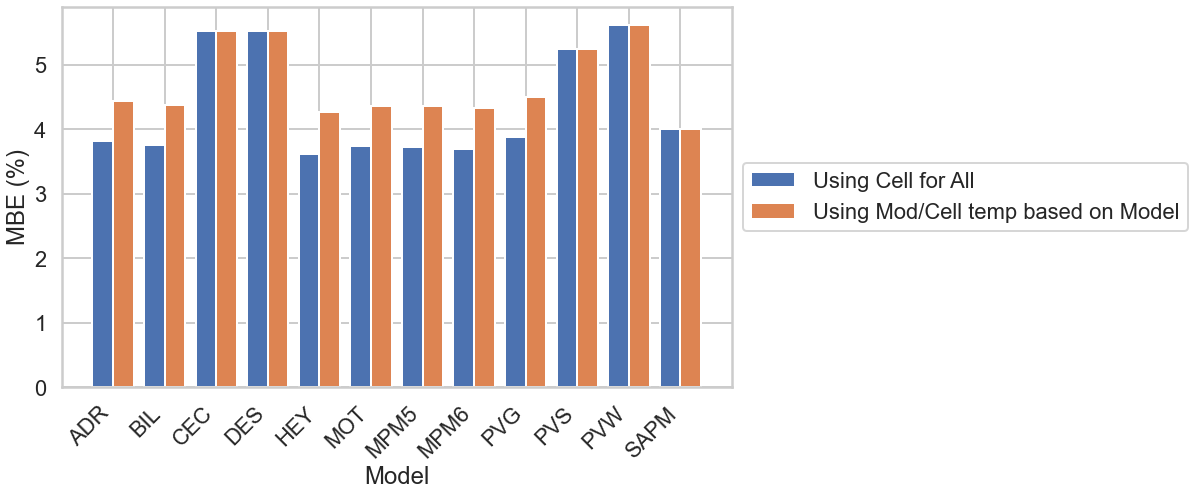

In [73]:

Y= all_modtemp['Cell Temp All']
Z = all_modtemp['Cell Temp']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Using Cell for All')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Using Mod/Cell temp based on Model')
  
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MBE (%)")
#plt.title("Mean bias error with and without considering ground diffuse irradiance")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.show()

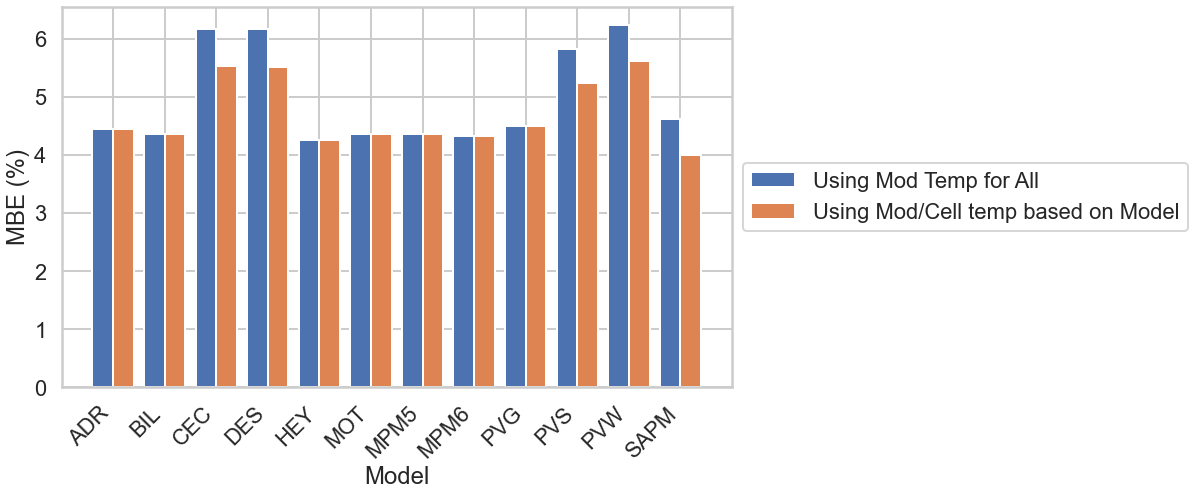

In [61]:

Y= all_modtemp['Mod Temp']
Z = all_modtemp['Cell Temp']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Using Mod Temp for All')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Using Mod/Cell temp based on Model')
  
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MBE (%)")
#plt.title("Mean bias error with and without considering ground diffuse irradiance")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
X = results_df.loc[results_df['System']=='Panasonic'].groupby(['Model Name']).mean().index
Y= results_df.loc[results_df['System']=='Panasonic'].groupby(['Model Name']).mean()['DGpower_%']
#Z = ngd_comp['GrDfs - DGpoa_W/m2']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis, Y, 0.4)
#plt.bar(X_axis + 0.2, Z, 0.4, label = 'Ground Diffuse Considered')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Name")
plt.ylabel("MBE (%)")
plt.title("Mean Bias Error of Performance Models")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')


In [75]:
results_df = pd.concat(results, ignore_index=True)
# results_df.index = results_df.Time
# results_df.to_hdf('results_df_all_irrtemp.h5', key='data', complib='zlib', complevel=9)

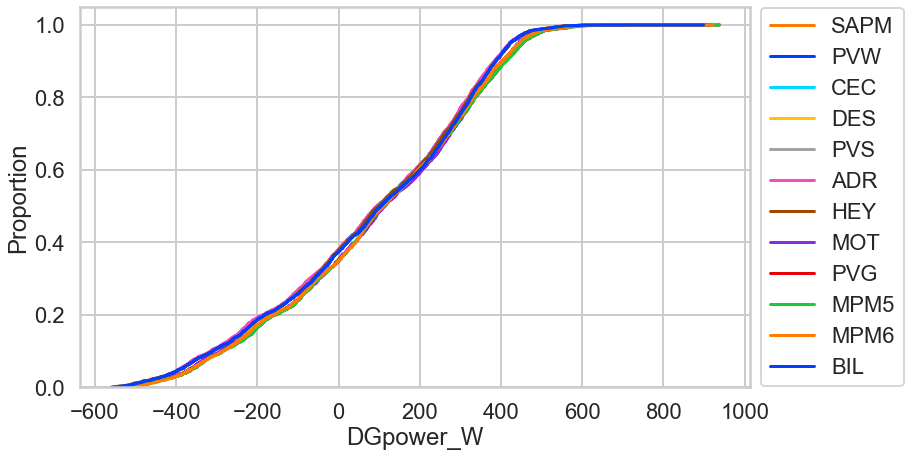

In [41]:
sns.ecdfplot(data=results_df.loc[results_df['System']=='Panasonic'], x='DGpower_W', hue='Model Name', palette='bright')
#plt.xlim(-150,150)
plt.ylim(0,1.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY','MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'] )

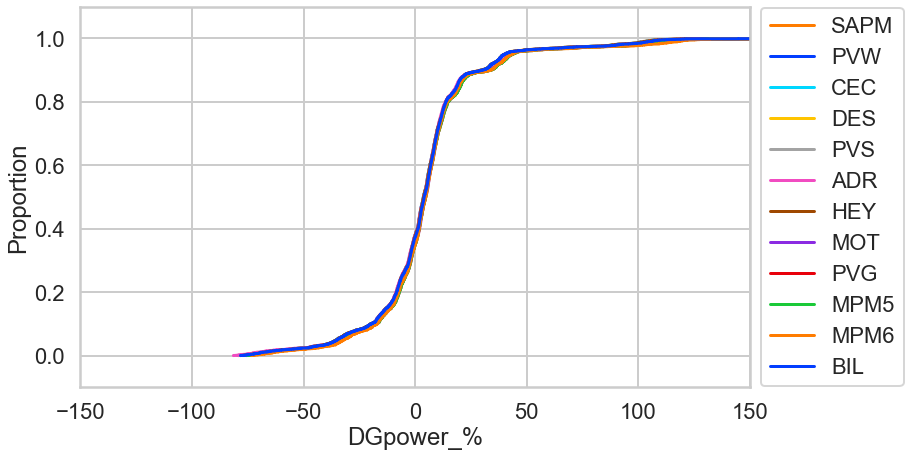

In [48]:
sns.ecdfplot(data=results_df.loc[results_df['System']=='Panasonic'], x='DGpower_%', hue='Model Name', palette='bright')
plt.xlim(-150,150)
plt.ylim(-0.1,1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=['SAPM', 'PVW', 'CEC', 'DES', 'PVS', 'ADR', 'HEY','MOT', 'PVG', 'MPM5', 'MPM6', 'BIL'] )

In [85]:
results_df.loc[results_df['System']=='Panasonic'].groupby(['Model Name']).mean()['DGpower_%']

Model Name
ADR     3.819675
BIL     3.748001
CEC     5.523693
DES     5.521233
HEY     3.609495
MOT     3.732145
MPM5    3.715098
MPM6    3.696463
PVG     3.880201
PVS     5.236136
PVW     5.615395
SAPM    3.997645
Name: DGpower_%, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'SAPM'),
  Text(1, 0, 'PVW'),
  Text(2, 0, 'CEC'),
  Text(3, 0, 'DES'),
  Text(4, 0, 'PVS'),
  Text(5, 0, 'ADR'),
  Text(6, 0, 'HEY'),
  Text(7, 0, 'MOT'),
  Text(8, 0, 'PVG'),
  Text(9, 0, 'MPM5'),
  Text(10, 0, 'MPM6'),
  Text(11, 0, 'BIL')])

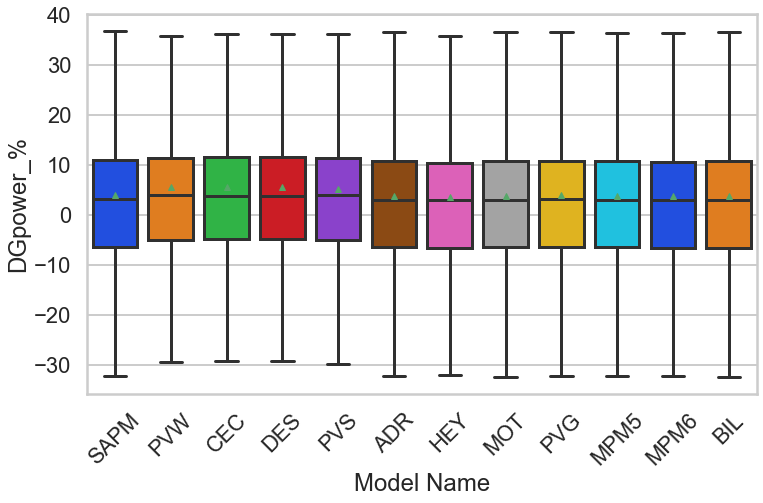

In [83]:
bp = sns.boxplot(data=results_df.loc[results_df['System']=='Panasonic'], x='Model Name', y='DGpower_%', palette='bright', showmeans=True, showfliers=False)
plt.xticks(rotation=45)

In [ ]:
#horizontal line ~5 to 6 %